# Assignment 3 - Hyperparameter Optimalization

In this assignment, we are tasked to perform supervised Machine Learning and incoporate Dask implementation and Hyperparameter Optimization.

We retrieved dataset from EuroSAT for land use and land cover (LULC). After pre-processing the data using Pandas dataframe and split the data for training and validation, we performed Decision Tree algorithm to create classifier model to classify the LULC classes. We also performed Hyperparameter Optimization to find the best parameter combination using the generated model. Lastly, we provided arguments over some discussion points about the overall assignment.

Below are the modules used in this assignment.

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import geojson

In [2]:
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
import time

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [4]:
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split

In [5]:
from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44631,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://127.0.0.1:44777,Total threads: 2
Dashboard: http://127.0.0.1:37501/status,Memory: 7.00 GiB
Nanny: tcp://127.0.0.1:33755,


In [6]:
directory_path = '/data/shared/Big-Geodata-Processing-2023-1A/Exercise3/EuroSAT_MS/'

In [7]:
# function to get the center coordinate of the image
def get_cent(filename):
    with rasterio.open(filename) as dataset:
        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'EPSG:4326', geom, precision=6)
            ls = list(geojson.utils.coords(geom))
            x = []
            y = []
            for row in ls:
                x.append(row[0])
                y.append(row[1])
            cent = [min(y)+(max(y)-min(y))/2,min(x)+(max(x)-min(x))/2]
    return cent

We selected several features to add from the data. 
- Mean of each image. Since each of EuroSAT image has been labeled according to its dominant landcover type contained inside that said image, we assumed that each landcover types has different distribution of RGB values in the image.
- Median of each image. The rationale is similar to that of mean, but instead of calculating the average value, we assumed that the median of the distributed value might has similar influence to recognize the dominant landcover inside each image.
- Range of each image. The rationale is simliar to that of mean and median, but we assumed that the wide of the distribution itself might has similar influence to recognize the dominant landcover inside each image.
- NDVI of each image.  NDVI measures the difference between near-infrared and red light reflected from vegetations. The index ranges from -1 to 1. Higher values indicate healthier or denser vegetation. NDVI also helps to differentiate vegetations and non-vegetation landcover such as water bodies. We assumed that this index will be helpful to recognize the images based on the landcover types.

Below are defined functions for each features.

In [8]:
def CalculateMean(filename_image):
    with rasterio.open(filename_image, 'r') as ds:
        img = ds.read()  # read all raster values
        rgb = img[1:4,:,:]
        return rgb.mean()

In [9]:
def CalculateMedian(filename_image):
    with rasterio.open(filename_image, 'r') as ds:
        img = ds.read()  # read all raster values
        rgb = img[1:4,:,:]
        return np.median(rgb)

In [10]:
def CalculateRange(filename_image):
    with rasterio.open(filename_image, 'r') as ds:
        img = ds.read()  # read all raster values
        rgb = img[1:4,:,:]
        return rgb.max() - rgb.min()

In [11]:
def CalculateNDVIMean(filename_image):
    with rasterio.open(filename_image, 'r') as ds:
        red = ds.read(4).astype('float32')
        nir = ds.read(8).astype('float32')
        
        mask = np.logical_or((nir + red) == 0, np.isnan(nir + red))
        ndvi = np.where(mask, 0, (nir - red) / (nir + red))
        np.seterr(divide='ignore', invalid='ignore')
        
        return  ndvi.mean()

Below are the code for converting the data and all features into dataframe.

In [12]:
# Creating the dataframe structure
df = pd.DataFrame(columns=["Lat", "Lon", "Class", "Mean", "Median", "Range", "NDVI"])

In [13]:
subfolders = [ f.path for f in os.scandir(directory_path) if f.is_dir() ]

In [14]:
#Populating the dataframe 
start_time = time.time()

for i in range(len(subfolders)):
    image_path = subfolders[i]
    class_name = os.path.basename(image_path)
    all_images = [f for f in os.listdir(image_path) if os.path.isfile(join(image_path, f))]
    
    for j in range(len(all_images)):
        cent = get_cent(image_path+'/'+all_images[j])
        imgmean = CalculateMean(image_path+'/'+all_images[j])
        imgmedian = CalculateMedian(image_path+'/'+all_images[j])
        imgrange = CalculateRange(image_path+'/'+all_images[j])
        imgndvimean = CalculateNDVIMean(image_path+'/'+all_images[j])
        new_row = pd.DataFrame({
            "Lat": cent[0],
            "Lon": cent[1],
            "Class": class_name,
            "Mean": imgmean,
            "Median": imgmedian,
            "Range": imgrange,
            "NDVI": imgndvimean
        }, index=[0])
        
        df = pd.concat([df, new_row], ignore_index=True)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 506.6010329723358 seconds


In [15]:
df

,Lat,Lon,Class,Mean,Median,Range,NDVI
0,51.636699,0.409756,Residential,926.669108,929.0,2572,0.331753
1,43.677658,7.113914,Residential,1109.703206,1071.0,2896,0.416689
2,51.630671,-0.732539,Residential,957.440999,973.0,1919,0.459261
3,52.333434,8.017260,Residential,897.033122,913.0,1558,0.381696
4,43.730154,7.160103,Residential,960.588949,906.0,5396,0.486914
...,...,...,...,...,...,...,...
26995,49.216428,16.408736,Highway,1198.619629,1075.5,4717,0.372000
26996,49.082481,2.728486,Highway,1499.752116,1442.0,2100,0.220752
26997,37.763857,-3.719099,Highway,1955.841797,1905.0,2414,0.164887
26998,50.744405,4.544050,Highway,924.569987,916.0,1542,0.530632


In [16]:
ddf = dd.from_pandas(df, npartitions=2)
ddf.head()

,Lat,Lon,Class,Mean,Median,Range,NDVI
0,51.636699,0.409756,Residential,926.669108,929.0,2572,0.331753
1,43.677658,7.113914,Residential,1109.703206,1071.0,2896,0.416689
2,51.630671,-0.732539,Residential,957.440999,973.0,1919,0.459261
3,52.333434,8.017260,Residential,897.033122,913.0,1558,0.381696
4,43.730154,7.160103,Residential,960.588949,906.0,5396,0.486914


# Decision Tree Algorithm

In this section, we performed Decision Tree algorithm for the supervised classification. The reason of this selection is because we defined this assignment to have simple, straightforward classification task based on landcover and include not too many features to address (four features mentioned above). The algorithm is suitable to handle data without requiring any normalisation. We are also helped by this algorithm's functionality to determine feature importance to find out which features are more important in determining landcover type of our images. Furthermore, Decision Tree algorithm has easy to understand rules and suitable for simple tasks.

In [17]:
# Changing the type of all columns to appropriate numerical type
ddf.astype({'NDVI': 'float64'})
ddf.astype({'Range': 'float64'})

# Dropping latitude and longitude as we are not using it as features for the machine learning
ddfnocoord = ddf.drop('Lat', axis=1)
ddfnocoord = ddfnocoord.drop('Lon', axis=1)
ddfnocoord.head()

,Class,Mean,Median,Range,NDVI
0,Residential,926.669108,929.0,2572,0.331753
1,Residential,1109.703206,1071.0,2896,0.416689
2,Residential,957.440999,973.0,1919,0.459261
3,Residential,897.033122,913.0,1558,0.381696
4,Residential,960.588949,906.0,5396,0.486914


In [18]:
# Splitting the data for training and validation test
X = ddfnocoord.drop('Class', axis=1)
y = ddfnocoord['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, shuffle=False)

In [19]:
# Creating Decision Tree classification model and fitting it to training dataset
model = DecisionTreeClassifier(random_state=100)

model.fit(X_train.compute(), y_train.compute())

# Measuring the accuracy of trained model through test dataset
accuracy = model.score(X_test, y_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.5915937803692906


  Feature  Importance
3    NDVI    0.346767
0    Mean    0.277886
2   Range    0.216999
1  Median    0.158348


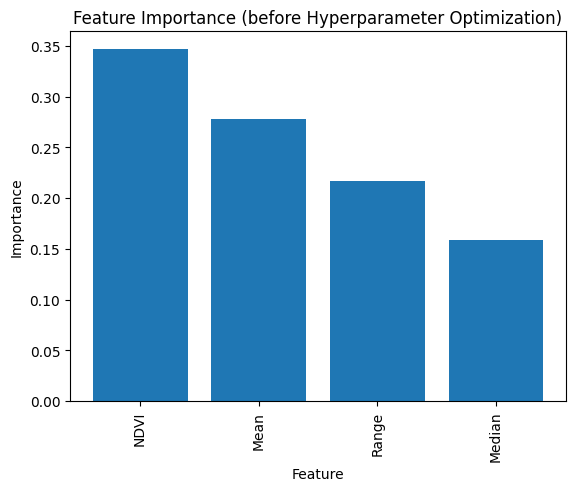

In [20]:
# Determining feature importance
feature_names = X.columns
result = model.feature_importances_
feature_importances = pd.DataFrame({"Feature": feature_names, "Importance": result})
feature_importances = feature_importances.sort_values("Importance", ascending=False)
print(feature_importances)

plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importance (before Hyperparameter Optimization)")
plt.show()

We observed NDVI as the most important feature the model addresses in classifying images based on the landcover, followed by Mean, Range, and lastly Median. This is a reasonable result as NDVI amongst all the addressed features is the most dependable index in differentiating vegetation and non-vegetation. Meanwhile, other than NDVI, the rest of the features are basic statistical property of the data.

It is interesting to observe that Mean has more importance than Median. This might be because it is more plausible to have the image to be represented by one calculated value using the whole image values (mean) compared to the mere middle-point of the data distribution.

It is also interesting to see Range to be important enough to not be the least importance. This makes sense since the landcover that label an image will dominate the content of the image, which influence the possibility of a distinctively different landcover with much smaller or higher value.

In [21]:
# Applying the model to predict test set for result validation
predictions = model.predict(X_test)
prediction_accuracy = accuracy_score(y_test, predictions)
print('Prediction Accuracy:', prediction_accuracy)

report = classification_report(y_test, predictions)
print(report)

Prediction Accuracy: 0.5915937803692906
                      precision    recall  f1-score   support

          AnnualCrop       0.54      0.54      0.54       898
              Forest       0.92      0.91      0.91       913
HerbaceousVegetation       0.44      0.43      0.43       926
             Highway       0.25      0.25      0.25       770
          Industrial       0.72      0.71      0.72       746
             Pasture       0.65      0.61      0.63       633
       PermanentCrop       0.39      0.43      0.41       768
         Residential       0.47      0.49      0.48       936
               River       0.56      0.53      0.54       772
             SeaLake       0.98      0.98      0.98       870

            accuracy                           0.59      8232
           macro avg       0.59      0.59      0.59      8232
        weighted avg       0.59      0.59      0.59      8232



After testing the model, we observed a 59.3% accuracy which is a very generic result. We also observed variying result of precision and recall from each landcover, which means the model is not very good in classifying all landcover after all. The model shows very good f1-scores (assumed as summarized value of precisoin and recall) for Forest and SeaLake landcover. This makes sense as NDVI can detect both landcover types very well. HIghway type has the least f1-score which also makes sense as this landcover type commonly a narrow feature on the map that can be surrounded by various landcover types.

# Hyperparameter Optimization

In this section, we performed Hyperparameter Optimization. This step systematically searches for the best hyperparameters for our Decition Tree machine learning model. This is achieved by fitting the model multiple times with different combinations of parameters.

In [22]:
# Define the grid of parameters to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [23]:
# Set up the grid for fitting
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid
start_time = time.time()
grid_search.fit(X_train.compute(), y_train.compute())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 17.379420280456543 seconds


In [24]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate on the test set
grid_accuracy = grid_search.score(X_test, y_test)
print("Test set accuracy with best parameters:", grid_accuracy)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test set accuracy with best parameters: 0.6126093294460642


  Feature  Importance
3    NDVI    0.435480
0    Mean    0.292842
2   Range    0.206754
1  Median    0.064925


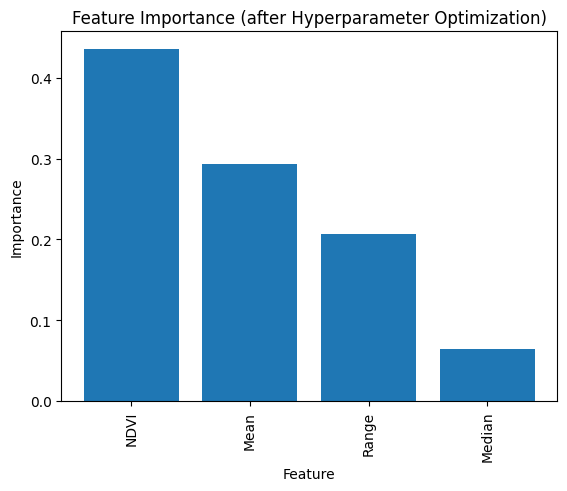

In [25]:
# Determining feature importance
best_estimator = grid_search.best_estimator_
fi = best_estimator.feature_importances_

feature_names = X.columns
feature_importances = pd.DataFrame({"Feature": feature_names, "Importance": fi})
feature_importances = feature_importances.sort_values("Importance", ascending=False)
print(feature_importances)

plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importance (after Hyperparameter Optimization)")
plt.show()

We observed that the order of importance is the same be it before or after implementing hyperparameter optimization (Pre-HPO or Post-HPO). However, we observed difference in the gaps between each features.

We see that Post-HPO NDVI feature has higher importance value compared with pre-HPO graph. Although we observed Mean has few increase, but both Range and Median lost their importance in the model. This is especially true to Median as it lost quite significant aomunt of feature importance value. This indicated that by using better combination of parameters, our model proved to work better in determining feature importance.

In [26]:
# Applying the model to predict test set for result validation (after Hyperparameter Optimization)
grid_predictions = grid_search.predict(X_test)
grid_accuracy = accuracy_score(y_test, grid_predictions)
print('Prediction Accuracy:', grid_accuracy)

grid_report = classification_report(y_test, grid_predictions)
print(grid_report)

Prediction Accuracy: 0.6126093294460642
                      precision    recall  f1-score   support

          AnnualCrop       0.57      0.54      0.56       898
              Forest       0.93      0.88      0.91       913
HerbaceousVegetation       0.39      0.55      0.46       926
             Highway       0.40      0.30      0.34       770
          Industrial       0.71      0.81      0.76       746
             Pasture       0.75      0.59      0.66       633
       PermanentCrop       0.40      0.47      0.44       768
         Residential       0.47      0.52      0.49       936
               River       0.69      0.43      0.53       772
             SeaLake       0.99      0.97      0.98       870

            accuracy                           0.61      8232
           macro avg       0.63      0.61      0.61      8232
        weighted avg       0.63      0.61      0.61      8232



We observed a slight increase in overall accuracy in our Post-HPO performance. This also indicates better parameter combination means better performance for the model.

In [27]:
client.shutdown()

# Discussion

In this section, some discussion points are elaborated.

## Can you explain the criteria and rationale behind the features you created? What other features you would select from these images in addition to the mean and range?

As mentioned before, here are the reasonings behind the selected features.
- Mean of each image. Since each of EuroSAT image has been labeled according to its dominant landcover type contained inside that said image, we assumed that each landcover types has different distribution of RGB values in the image.
- Median of each image. The rationale is similar to that of mean, but instead of calculating the average value, we assumed that the median of the distributed value might has similar influence to recognize the dominant landcover inside each image.
- Range of each image. The rationale is simliar to that of mean and median, but we assumed that the wide of the distribution itself might has similar influence to recognize the dominant landcover inside each image.
- NDVI of each image.  NDVI measures the difference between near-infrared and red light reflected from vegetations. The index ranges from -1 to 1. Higher values indicate healthier or denser vegetation. NDVI also helps to differentiate vegetations and non-vegetation landcover such as water bodies. We assumed that this index will be helpful to recognize the images based on the landcover types.

## Why is it important to have separate sets for training, validation, and testing? Which split did you consider and why?

Splitting the dataset for training, validation, and testing is essential to validate and evaluate the generated machine learning model performance. The split ratio among these sets can vary. We decided to use 70% training data and 30% test data ratio as it provides balance between enough data the model can learn from and having enough data to evaluate the model performance.

## What factors influenced your choice of a specific machine learning algorithm?

As mentioned before, here are the reason why we chose Decision Tree algorithm for this task.

- We defined this assignment to have simple, straightforward classification task based on landcover and include not too many features to address (four features mentioned above).
- Decision Tree algorithm is suitable to handle data without requiring any normalisation.
- We are also helped by this algorithm's functionality to determine feature importance to find out which features are more important in determining landcover type of our images.
- Decision Tree algorithm has easy to understand rules and suitable for simple tasks.

## How did hyperparameter tuning impact the model's performance, and what were the final hyperparameter settings?

As mentioned before, below are some observations made from hyperparameter optimization implementation.
- We observed that the order of importance is the same be it before or after implementing hyperparameter optimization (Pre-HPO or Post-HPO). However, we observed difference in the gaps between each features.
- We observed that Post-HPO NDVI feature has higher importance value compared with pre-HPO graph. Although we observed Mean has few increase, but both Range and Median lost their importance in the model. This is especially true to Median as it lost quite significant aomunt of feature importance value. This indicated that by using better combination of parameters, our model proved to work better in determining feature importance.
- We observed a slight increase in overall accuracy in our Post-HPO performance. This also indicates better parameter combination means better performance for the model.

## What is the impact of using DASK to solve this problem?

We implemented Dask in this assignment as shown on our implemented code above. However, we were unable to find a reproducible answer to this question as to how to show Dask influence in our code — other than us doing manually comparation of the time it took to run the classifier using both normal Pandas & Dask dataframe and during splitting the dataset for training & testing. Dask is proved to the faster although we failed to document the exact time. This unfortunate result becomes our evaluation in this assignment.